## <h3><center><b>Showing the seam (less energy) of applied seam carving algorithm in an image.</b></center></h3>

In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Draw vertical seam on top of the image
def overlay_vertical_seam(img, seam):
    img_seam_overlay = np.copy(img)

    # Extract the list of points from the seam
    x_coords, y_coords = np.transpose([(i, int(j)) for i, j in enumerate(seam)])

    # Draw a green line on the image using the list of points buraya eklendi
    img_seam_overlay[x_coords, y_coords] = (0, 255,0)
    return img_seam_overlay

In [16]:
# Compute the energy matrix from the input image
def compute_energy_matrix(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    return cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)

In [17]:
# Find the vertical seam
def find_vertical_seam(img, energy):
    rows, cols = img.shape[:2]

    # Initialize the seam vector with 0 for each element
    seam = np.zeros(img.shape[0])

    # Initialize distance and edge matrices
    dist_to = np.zeros(img.shape[:2]) + float('inf')
    dist_to[0, :] = np.zeros(img.shape[1])
    edge_to = np.zeros(img.shape[:2])

    # Dynamic programming; iterate using double loop and compute
    # the paths efficiently
    for row in range(rows - 1):
        for col in range(cols):
            if col != 0 and \
                    dist_to[row + 1, col - 1] > dist_to[row, col] + energy[row + 1, col - 1]:
                dist_to[row + 1, col - 1] = dist_to[row, col] + energy[row + 1, col - 1]
                edge_to[row + 1, col - 1] = 1

            if dist_to[row + 1, col] > dist_to[row, col] + energy[row + 1, col]:
                dist_to[row + 1, col] = dist_to[row, col] + energy[row + 1, col]
                edge_to[row + 1, col] = 0

            if col != cols - 1:
                if dist_to[row + 1, col + 1] > dist_to[row, col] + energy[row + 1, col + 1]:
                    dist_to[row + 1, col + 1] = dist_to[row, col] + energy[row + 1, col + 1]
                    edge_to[row + 1, col + 1] = -1

    # Retracing the path
    seam[rows - 1] = np.argmin(dist_to[rows - 1, :])
    for i in (x for x in reversed(range(rows)) if x > 0):
        seam[i - 1] = seam[i] + edge_to[i, int(seam[i])]

    return seam

In [18]:
# Add a vertical seam to the image
def add_vertical_seam(img, seam, num_iter):
    seam = seam + num_iter
    rows, cols = img.shape[:2]
    zero_col_mat = np.zeros((rows, 1, 3), dtype=np.uint8)
    img_extended = np.hstack((img, zero_col_mat))

    for row in range(rows):
        for col in range(cols, int(seam[row]), -1):
            img_extended[row, col] = img[row, col - 1]

            # To insert a value between two columns, take the average
        # value of the neighbors. It looks smooth this way and we
        # can avoid unwanted artifacts.
        for i in range(3):
            v1 = img_extended[row, int(seam[row]) - 1, i]
            v2 = img_extended[row, int(seam[row]) + 1, i]
            img_extended[row, int(seam[row]), i] = (int(v1) + int(v2)) / 2

    return img_extended


# Remove vertical seam from the image
def remove_vertical_seam(img, seam):
    rows, cols = img.shape[:2]
    for row in range(rows):
        for col in range(int(seam[row]), cols - 1):
            img[row, col] = img[row, col + 1]

    img = img[:, 0:cols - 1]
    return img

## Main 

Text(0.5, 1.0, 'Enerji Of image')

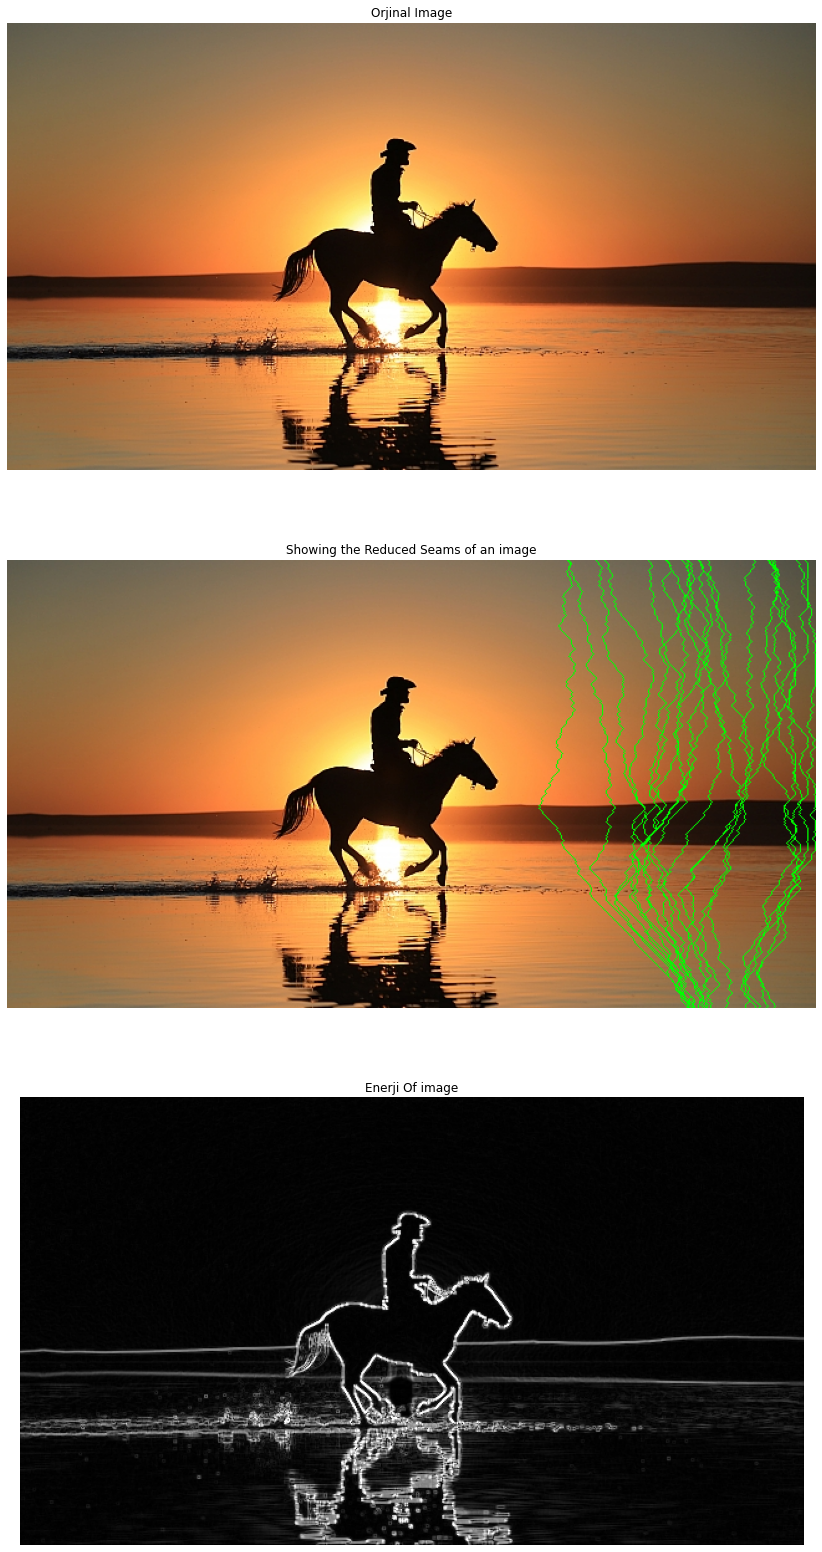

In [21]:
img_input = cv2.imread("atliadam.jpg")
img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)

num_seams = 20 # percentage of image
img = np.copy(img_input)
img_output = np.copy(img_input)
img_overlay_seam = np.copy(img_input)
energy = compute_energy_matrix(img)

for i in range(num_seams):
    seam = find_vertical_seam(img, energy)
    img_overlay_seam = overlay_vertical_seam(img_overlay_seam, seam)
    img = remove_vertical_seam(img, seam)
    #img_output = add_vertical_seam(img_output, seam, i)
    energy = compute_energy_matrix(img)
    #print('Number of seams added =', i + 1)

fig = plt.figure(figsize=(40, 28))
  
# setting values to rows and column variables
rows = 3
columns = 1
fig.add_subplot(rows, columns, 1)
  

plt.imshow(img_input,cmap='gray')
plt.axis('off')
plt.title("Orjinal Image")
  
fig.add_subplot(rows, columns, 2)
  
plt.imshow(img_overlay_seam,cmap='gray')
plt.axis('off')
plt.title("Showing the Reduced Seams of an image")    
    
fig.add_subplot(rows, columns, 3)
  
plt.imshow(energy,cmap='gray')
plt.axis('off')
plt.title("Enerji Of image")
  